In [2]:
import ee
import geemap
import pandas as pd
from ccdc import get_preprocessed_Sentinel2, add_ccdc_lambda

ee.Initialize()

# FAO = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0")
# country = FAO.filter(ee.Filter.eq("ADM0_NAME", "Colombia"))

""" Sample time series over a given point """
# point = ee.Geometry.Point([-72.19594365263514, 4.556298580150745])

def sample_location(row):
    print(row.longitude, row.latitude)
    point = ee.Geometry.Point([row.longitude, row.latitude])

    def sample_time_series(image):
        return image.reduceRegions(collection=ee.FeatureCollection([point]), reducer=ee.Reducer.mean(), scale=10)\
                    .map(lambda x: x.set({
                                            'FoY': image.get('FoY'),
                                            'lon': row.longitude,
                                            'lat': row.latitude
                                        })
                        )
    
    s2ImgCol = get_preprocessed_Sentinel2({
        'region': point,
        'start_date': '2017-01-01',
        'end_date': '2025-01-01',
        'maskCloud': True
    })

    add_s2_l005 = add_ccdc_lambda('s2-sr', 'l005')
    s2ImgCol_ccdc = s2ImgCol.map(add_s2_l005)

    time_series = ee.FeatureCollection(s2ImgCol_ccdc.map(sample_time_series).flatten())
    df = geemap.ee_to_df(time_series)
    df_multi_index = pd.concat(df.to_list(), axis=0, keys=df.index.values)
    return df

# df = sample_location(row)

# # create meta data for dask 
# meta = {}
# for col in df.columns:
#     meta[col] = 'float'


pntfc_worldCover = pd.read_csv("data/WorldCover_Stratified_1k_per_cls.csv")
pntfc_wetMask = pd.read_csv("data/wetland_mask_Stratified_5k_per_cls.csv")
# pntfc = pntfc_worldCover
pntfc = pntfc_worldCover[pntfc_worldCover['wetland_label']==4]
rows = pntfc_worldCover.loc[137:138]

df = rows.apply(sample_location, axis=1) 

df

-72.30148954729437 4.435386799575931
-70.56513593461975 -0.2532799943574991


137            B11  B11_l005     B12  B12_l005      B...
138         B11_l005  B12_l005   B2_l005   B3_l005   ...
dtype: object

In [67]:
df1 = pd.concat(df.to_list(), axis=0, keys=df.index.values)
df1.index.names = ['pnt_idx', 'seq_idx']
# df1.to_csv("outputs/empty.csv")
df1

B11  B11_l005     B12  B12_l005      B2   B2_l005      B3  \
137 0    0.4470  0.413240  0.2438  0.207353  0.0666  0.063992  0.1026   
    1    0.4470  0.413240  0.2438  0.207353  0.0646  0.063992  0.1018   
    2    0.4182  0.414016  0.2170  0.207936  0.0694  0.062681  0.1070   
    3    0.4188  0.414016  0.2170  0.207936  0.0662  0.062681  0.1050   
    4       NaN  0.415417     NaN  0.208961     NaN  0.061746     NaN   
...         ...       ...     ...       ...     ...       ...     ...   
138 368     NaN  0.297777     NaN  0.115709     NaN  0.069421     NaN   
    369     NaN  0.296456     NaN  0.115412     NaN  0.069375     NaN   
    370     NaN  0.295225     NaN  0.115233     NaN  0.069526     NaN   
    371     NaN  0.294092     NaN  0.115172     NaN  0.069806     NaN   
    372     NaN  0.293065     NaN  0.115222     NaN  0.070146     NaN   

          B3_l005      B4   B4_l005  ...   B8_l005          FoY       lat  \
137 0    0.107870  0.0844  0.081941  ...  0.536818  2018.958904  4.435387   
    1    0.107870  0.0836  0.081941  ...  0.536818  2018.958904  4.435387   
    2    0.106853  0.0852  0.081998  ...  0.536368  2018.972603  4.435387   
    3    0.106853  0.0832  0.081998  ...  0.536368  2018.972603  4.435387   
    4    0.106370     NaN  0.082517  ...  0.536820  2018.986301  4.435387   
...           ...     ...       ...  ...       ...          ...       ...   
138 368  0.097397     NaN  0.062793  ...  0.541533  2024.057377 -0.253280   
    369  0.096686     NaN  0.062718  ...  0.536676  2024.071038 -0.253280   
    370  0.096172     NaN  0.062752  ...  0.532344  2024.084699 -0.253280   
    371  0.095816     NaN  0.062852  ...  0.528585  2024.098361 -0.253280   
    372  0.095573     NaN  0.062975  ...  0.525432  2024.112022 -0.253280   

               lon      ndvi  ndvi_l005      ndwi  ndwi_l005     water  \
137 0   -72.301490  0.840634   0.864049  0.187295   0.174977  0.112261   
    1   -72.301490  0.842145   0.864049  0.185834   0.174977  0.109249   
    2   -72.301490  0.848614   0.864274  0.183031   0.173178  0.101719   
    3   -72.301490  0.852273   0.864274  0.179487   0.173178  0.095138   
    4   -72.301490       NaN   0.864103       NaN   0.171682       NaN   
...            ...       ...        ...       ...        ...       ...   
138 368 -70.565136       NaN   0.899134       NaN   0.152842       NaN   
    369 -70.565136       NaN   0.898312       NaN   0.153662       NaN   
    370 -70.565136       NaN   0.897369       NaN   0.154618       NaN   
    371 -70.565136       NaN   0.896398       NaN   0.155626       NaN   
    372 -70.565136       NaN   0.895489       NaN   0.156603       NaN   

         water_l005  
137 0      0.114798  
    1      0.114798  
    2      0.108802  
    3      0.108802  
    4      0.103629  
...             ...  
138 368    0.040179  
    369    0.040326  
    370    0.041031  
    371    0.042138  
    372    0.043477  

[1121 rows x 29 columns]

In [48]:
df1.shape

(1121, 29)

In [46]:
df1.columns

Index(['B11', 'B11_l005', 'B12', 'B12_l005', 'B2', 'B2_l005', 'B3', 'B3_l005',
       'B4', 'B4_l005', 'B5', 'B5_l005', 'B6', 'B6_l005', 'B7', 'B7_l005',
       'B8', 'B8A', 'B8A_l005', 'B8_l005', 'FoY', 'lat', 'lon', 'ndvi',
       'ndvi_l005', 'ndwi', 'ndwi_l005', 'water', 'water_l005'],
      dtype='object')

In [29]:
df1.loc[138]

,B11,B11_l005,B12,B12_l005,B2,B2_l005,B3,B3_l005,B4,B4_l005,...,B8_l005,FoY,lat,lon,ndvi,ndvi_l005,ndwi,ndwi_l005,water,water_l005
0,NaN,0.287407,NaN,0.121470,NaN,0.079654,NaN,0.110605,NaN,0.069068,...,0.538648,2018.950685,-0.25328,-70.565136,NaN,0.893463,NaN,0.157892,NaN,0.109896
1,NaN,0.285756,NaN,0.120497,NaN,0.077505,NaN,0.108382,NaN,0.067793,...,0.532696,2018.964384,-0.25328,-70.565136,NaN,0.894921,NaN,0.156467,NaN,0.104712
2,NaN,0.284105,NaN,0.119562,NaN,0.075500,NaN,0.106211,NaN,0.066590,...,0.526517,2018.978082,-0.25328,-70.565136,NaN,0.896157,NaN,0.155262,NaN,0.099862
3,NaN,0.282467,NaN,0.118682,NaN,0.073716,NaN,0.104164,NaN,0.065509,...,0.520223,2018.991781,-0.25328,-70.565136,NaN,0.897102,NaN,0.154340,NaN,0.095548
4,NaN,0.280854,NaN,0.117875,NaN,0.072212,NaN,0.102298,NaN,0.064589,...,0.513930,2019.005479,-0.25328,-70.565136,NaN,0.897712,NaN,0.153744,NaN,0.091925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,NaN,0.297777,NaN,0.115709,NaN,0.069421,NaN,0.097397,NaN,0.062793,...,0.541533,2024.057377,-0.25328,-70.565136,NaN,0.899134,NaN,0.152842,NaN,0.040179
369,NaN,0.296456,NaN,0.115412,NaN,0.069375,NaN,0.096686,NaN,0.062718,...,0.536676,2024.071038,-0.25328,-70.565136,NaN,0.898312,NaN,0.153662,NaN,0.040326
370,NaN,0.295225,NaN,0.115233,NaN,0.069526,NaN,0.096172,NaN,0.062752,...,0.532344,2024.084699,-0.25328,-70.565136,NaN,0.897369,NaN,0.154618,NaN,0.041031
371,NaN,0.294092,NaN,0.115172,NaN,0.069806,NaN,0.095816,NaN,0.062852,...,0.528585,2024.098361,-0.25328,-70.565136,NaN,0.896398,NaN,0.155626,NaN,0.042138


In [78]:
from pathlib import Path 
save_url = Path("outputs/sampled_ts_data_WorldCover_stratified_V1.csv")
col_names = ['B11', 'B11_l005', 'B12', 'B12_l005', 'B2', 'B2_l005', 'B3', 'B3_l005',
    'B4', 'B4_l005', 'B5', 'B5_l005', 'B6', 'B6_l005', 'B7', 'B7_l005',
    'B8', 'B8A', 'B8A_l005', 'B8_l005', 'FoY', 'lat', 'lon', 'ndvi',
    'ndvi_l005', 'ndwi', 'ndwi_l005', 'water', 'water_l005']

# index = pd.MultiIndex.from_tuples([], names=['pnt_idx', 'seq_idx'])
# df = pd.DataFrame([], index=index, columns=col_names)
# df.to_csv(save_url)

In [102]:
index_names = ['pnt_idx', 'seq_idx']
df0 = pd.concat([pd.DataFrame([], columns=index_names + col_names)], axis=0)
df0 = df0.set_index(index_names)
df0.to_csv("outputs/empty2.csv")

df0

,,B11,B11_l005,B12,B12_l005,B2,B2_l005,B3,B3_l005,B4,B4_l005,...,B8_l005,FoY,lat,lon,ndvi,ndvi_l005,ndwi,ndwi_l005,water,water_l005
pnt_idx,seq_idx,,,,,,,,,,,,,,,,,,,,,


In [146]:
df_ = pd.read_csv("data\WorldCover_Stratified_1k_per_cls.csv")
df_.drop(index=2677)
df_

<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\W'


C:\Users\puzh\AppData\Local\Temp\ipykernel_34576\2061748870.py:1: SyntaxWarning: invalid escape sequence '\W'
  df_ = pd.read_csv("data\WorldCover_Stratified_1k_per_cls.csv")


,system:index,WorldCover,latitude,longitude,wetland_label,wetland_mask,.geo
0,0,10,1.643064,-71.818376,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1,10,-2.015415,-70.370741,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2,10,3.378609,-69.672121,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,3,10,3.844655,-76.207814,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,4,10,-0.810235,-71.343885,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...,...,...,...
10500,10500,100,2.269728,-76.357383,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
10501,10501,100,1.205315,-77.361161,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
10502,10502,100,2.266764,-76.347951,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
10503,10503,100,6.526485,-72.410455,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [3]:
import pandas as pd

df_ = pd.read_csv("outputs\sampled_ts_data_WorldCover_stratified_V1_2626_2726.csv").set_index(['pnt_idx', 'seq_idx'])
df_

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\puzh\AppData\Local\Temp\ipykernel_20772\46679160.py:3: SyntaxWarning: invalid escape sequence '\s'
  df_ = pd.read_csv("outputs\sampled_ts_data_WorldCover_stratified_V1_2626_2726.csv").set_index(['pnt_idx', 'seq_idx'])


B11  B11_l005     B12  B12_l005      B2   B2_l005      B3  \
pnt_idx seq_idx                                                                 
2626    0        0.4050  0.374639  0.2300  0.213179  0.0588  0.073949  0.1098   
        1           NaN  0.373297     NaN  0.213219     NaN  0.073045     NaN   
        2        0.3562  0.373143  0.2038  0.213849  0.0438  0.072327  0.1000   
        3        0.3746  0.374261  0.2332  0.215099  0.0584  0.071821  0.1180   
        4           NaN  0.376682     NaN  0.216976     NaN  0.071551     NaN   
...                 ...       ...     ...       ...     ...       ...     ...   
2599    370         NaN  0.588988     NaN  0.361032     NaN  0.115673     NaN   
        371         NaN  0.594982     NaN  0.372765     NaN  0.118006     NaN   
        372         NaN  0.600922     NaN  0.384717     NaN  0.120792     NaN   
        373         NaN  0.606659     NaN  0.396635     NaN  0.123973     NaN   
        374         NaN  0.612044     NaN  0.408255     NaN  0.127471     NaN   

                  B3_l005      B4   B4_l005  ...   B8_l005          FoY  \
pnt_idx seq_idx                              ...                          
2626    0        0.123892  0.0802  0.101155  ...  0.539498  2018.953425   
        1        0.123007     NaN  0.100238  ...  0.540544  2018.967123   
        2        0.122426  0.0808  0.099630  ...  0.540624  2018.980822   
        3        0.122155  0.0982  0.099341  ...  0.539741  2018.994521   
        4        0.122198     NaN  0.099373  ...  0.538003  2019.008219   
...                   ...     ...       ...  ...       ...          ...   
2599    370      0.155314     NaN  0.179179  ...  0.410114  2024.057377   
        371      0.156489     NaN  0.182296  ...  0.402068  2024.071038   
        372      0.158142     NaN  0.185497  ...  0.394834  2024.084699   
        373      0.160225     NaN  0.188730  ...  0.388516  2024.098361   
        374      0.162674     NaN  0.191940  ...  0.383196  2024.112022   

                      lat        lon      ndvi  ndvi_l005      ndwi  \
pnt_idx seq_idx                                                       
2626    0        4.337560 -73.953042  0.858952   0.848665  0.183551   
        1        4.337560 -73.953042       NaN   0.850310       NaN   
        2        4.337560 -73.953042  0.848234   0.851422  0.181291   
        3        4.337560 -73.953042  0.833953   0.851959  0.193063   
        4        4.337560 -73.953042       NaN   0.851899       NaN   
...                   ...        ...       ...        ...       ...   
2599    370      5.064118 -70.509171       NaN   0.696599       NaN   
        371      5.064118 -70.509171       NaN   0.688631       NaN   
        372      5.064118 -70.509171       NaN   0.680857       NaN   
        373      5.064118 -70.509171       NaN   0.673412       NaN   
        374      5.064118 -70.509171       NaN   0.666429       NaN   

                 ndwi_l005     water  water_l005  
pnt_idx seq_idx                                   
2626    0         0.186907  0.096933    0.114152  
        1         0.185906       NaN    0.109376  
        2         0.185234  0.099587    0.105181  
        3         0.184912  0.125339    0.101804  
        4         0.184948       NaN    0.099466  
...                    ...       ...         ...  
2599    370       0.278122       NaN    0.500402  
        371       0.283319       NaN    0.530227  
        372       0.288702       NaN    0.560537  
        373       0.294178       NaN    0.590765  
        374       0.299649       NaN    0.620319  

[1009002 rows x 29 columns]

In [10]:
len(pnt_idx_dist)

1108

In [26]:
not_nan_mask = df_['B12'].notna()
row_indices = not_nan_mask[not_nan_mask].index

pnt_idx_list = set([pnt_idx for pnt_idx, _ in list(row_indices)])
pnt_idx_list

{2049,
 2051,
 2052,
 2054,
 2056,
 2059,
 2061,
 2065,
 2066,
 2069,
 2070,
 2071,
 2072,
 2073,
 2077,
 2081,
 2082,
 2083,
 2084,
 2085,
 2087,
 2090,
 2092,
 2093,
 2094,
 2098,
 2099,
 2100,
 2106,
 2109,
 2110,
 2111,
 2113,
 2116,
 2117,
 2119,
 2120,
 2124,
 2125,
 2126,
 2127,
 2129,
 2132,
 2133,
 2134,
 2135,
 2138,
 2139,
 2140,
 2141,
 2142,
 2148,
 2152,
 2153,
 2154,
 2155,
 2156,
 2157,
 2159,
 2161,
 2162,
 2163,
 2164,
 2166,
 2167,
 2171,
 2172,
 2175,
 2177,
 2180,
 2183,
 2186,
 2187,
 2188,
 2190,
 2193,
 2195,
 2196,
 2198,
 2200,
 2202,
 2203,
 2205,
 2206,
 2207,
 2209,
 2212,
 2213,
 2219,
 2220,
 2221,
 2223,
 2225,
 2227,
 2229,
 2230,
 2232,
 2233,
 2236,
 2237,
 2238,
 2242,
 2247,
 2248,
 2250,
 2251,
 2256,
 2257,
 2258,
 2261,
 2263,
 2265,
 2268,
 2271,
 2272,
 2273,
 2275,
 2277,
 2282,
 2284,
 2288,
 2290,
 2292,
 2293,
 2296,
 2297,
 2298,
 2299,
 2301,
 2303,
 2304,
 2308,
 2310,
 2311,
 2314,
 2315,
 2316,
 2317,
 2318,
 2320,
 2322,
 2323,
 2324,

In [45]:
import numpy as np

X = df_.loc[2049][['FoY', 'B12']]
X['const'] = 1
X = X.rename(columns={'FoY': 't'})
X['cos2pt'] = X['t'].transform(lambda t: np.cos(2*np.pi*t))
X['sin2pt'] = X['t'].transform(lambda t: np.sin(2*np.pi*t))
X['cos4pt'] = X['t'].transform(lambda t: np.cos(4*np.pi*t))
X['sin4pt'] = X['t'].transform(lambda t: np.sin(4*np.pi*t))
X['cos6pt'] = X['t'].transform(lambda t: np.cos(6*np.pi*t))
X['sin6pt'] = X['t'].transform(lambda t: np.sin(6*np.pi*t))

X = X[['const', 't', 'cos2pt', 'sin2pt', 'cos4pt', 'sin4pt', 'cos6pt', 'sin6pt', 'B12']]
X = X.dropna()
X

,const,t,cos2pt,sin2pt,cos4pt,sin4pt,cos6pt,sin6pt,B12
seq_idx,,,,,,,,,
0,1,2018.950685,0.952378,-0.304921,0.814046,-0.580800,0.598181,-0.801361,0.2010
1,1,2018.964384,0.975065,-0.221922,0.901502,-0.432776,0.782980,-0.622047,0.1796
2,1,2018.978082,0.990532,-0.137279,0.962309,-0.271958,0.915864,-0.401488,0.2296
3,1,2018.991781,0.998667,-0.051620,0.994671,-0.103102,0.988023,-0.154309,0.2396
4,1,2019.005479,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102,0.1356
...,...,...,...,...,...,...,...,...,...
367,1,2024.043716,0.962513,0.271234,0.852864,0.522133,0.679273,0.733885,0.2364
368,1,2024.057377,0.935717,0.352752,0.751132,0.660152,0.469977,0.882679,0.2410
369,1,2024.071038,0.902030,0.431673,0.627317,0.778764,0.229688,0.973264,0.2478


In [43]:


X_train.shape

(374, 8)

In [47]:
from sklearn.linear_model import LassoCV
import numpy as np

# Assuming X_train and y_train are your features and target variable respectively
# X_train, y_train = np.random.rand(100, 10), np.random.rand(100)
X_train = X[['const', 't', 'cos2pt', 'sin2pt', 'cos4pt', 'sin4pt', 'cos6pt', 'sin6pt']].values
y_train = X[['B8']].values

# Create a LassoCV object
lasso_cv = LassoCV(cv=10, random_state=0, max_iter=10000)

# Fit model
lasso_cv.fit(X_train, y_train)

# Optimal lambda value
optimal_lambda = lasso_cv.alpha_
print("Optimal lambda (alpha) value:", optimal_lambda)


KeyError: "None of [Index(['B8'], dtype='object')] are in the [columns]"

In [ ]:
import matplotlib.pyplot as plt

for pnt_idx in [2070,
                2071,
                2072,
                2073,]:
    
    bandList = ['B4', 'B8', 'B12', 'ndvi', 'ndwi', 'water']

    df2plt = df_.loc[pnt_idx]
    fig, ax = plt.subplots(nrows=len(bandList), ncols=1, sharex=True)
    for idx, band in enumerate(bandList):
        df2plt.plot(ax=ax[idx], kind='line', x='FoY', y=[band, f'{band}_l005'], figsize=(12,18))

    fig.tight_layout() 
    fig.savefig(f"outputs/time_series_raw_vs_ccdc_{pnt_idx}.png")
    plt.close()

In [22]:
pnt_idx = 2094
fig.savefig(f"outputs/time_series_raw_vs_ccdc_{pnt_idx}.png")

In [104]:
df_sum

137             B1     B11  B11_l005     B12  B12_l00...
138         B11_l005  B12_l005   B2_l005   B3_l005   ...
139             B1     B11  B11_l005     B12  B12_l00...
140                 FoY       lat        lon
0    201...
dtype: object

In [127]:
df1 = pd.read_csv("outputs/dask_debug.csv")
df1

,Unnamed: 0,B11 B11_l005 B12 B12_l005 B2 B2_l005 B3 B3_l005 B4 B4_l005 ... B8_l005 FoY lat lon ndvi ndvi_l005 ndwi ndwi_l005 water water_l005
0,0,0 0.4470 0.413240 0.2438 0.207353 0.066...
1,1,1 0.4470 0.413240 0.2438 0.207353 0.064...
2,2,2 0.4182 0.414016 0.2170 0.207936 0.069...
3,3,3 0.4188 0.414016 0.2170 0.207936 0.066...
4,4,4 NaN 0.415417 NaN 0.208961 Na...
5,5,.. ... ... ... ... .....
6,6,743 0.3554 0.378417 0.1566 0.165669 0.068...
7,7,744 NaN 0.383834 NaN 0.169306 Na...
8,8,745 NaN 0.383834 NaN 0.169306 Na...
9,9,746 NaN 0.389354 NaN 0.172995 Na...


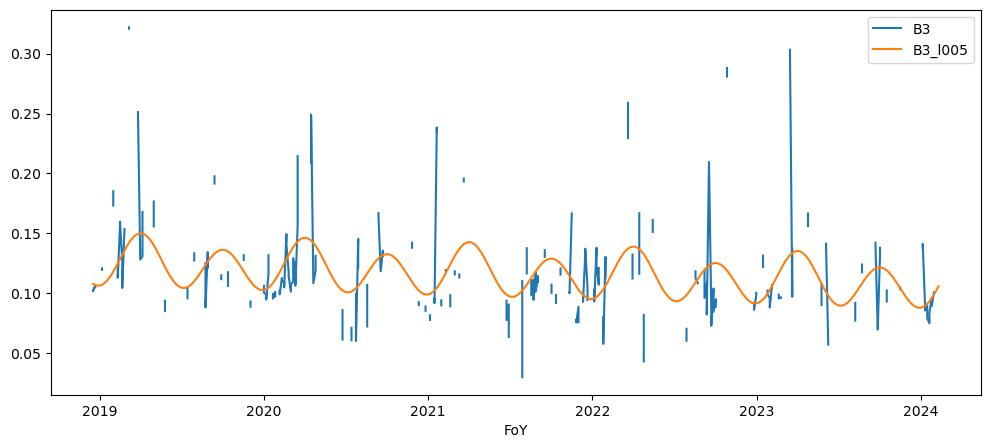

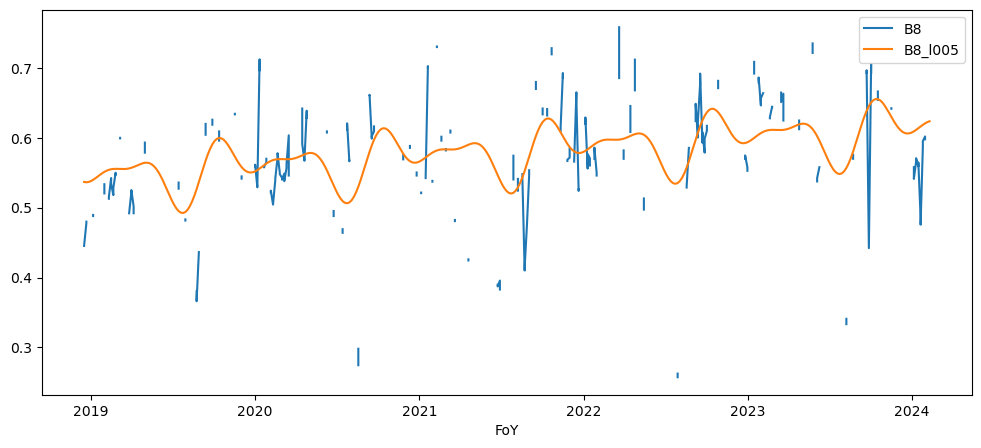

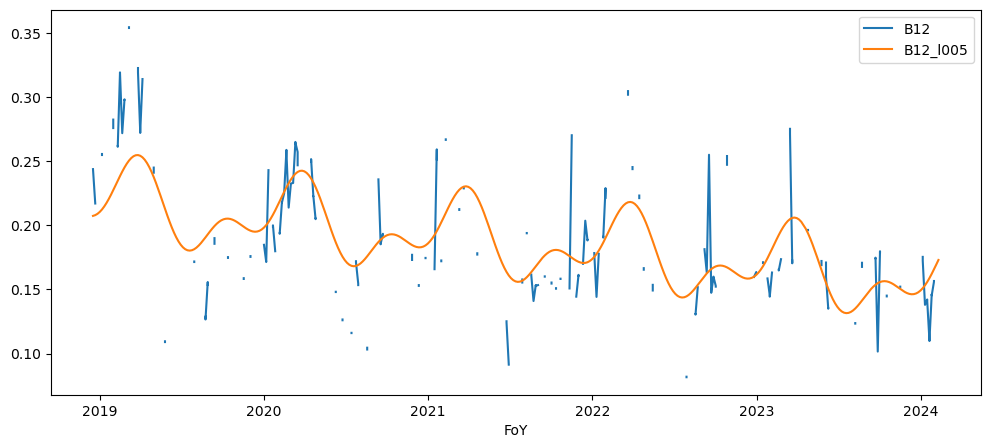

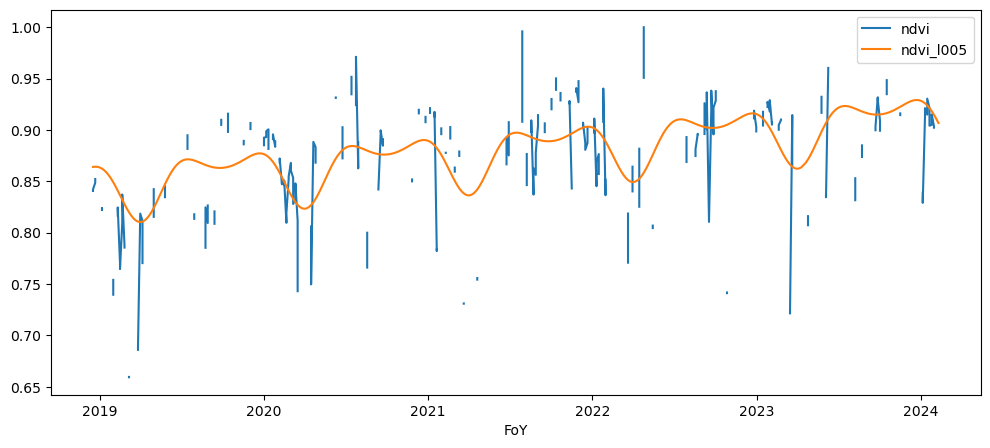

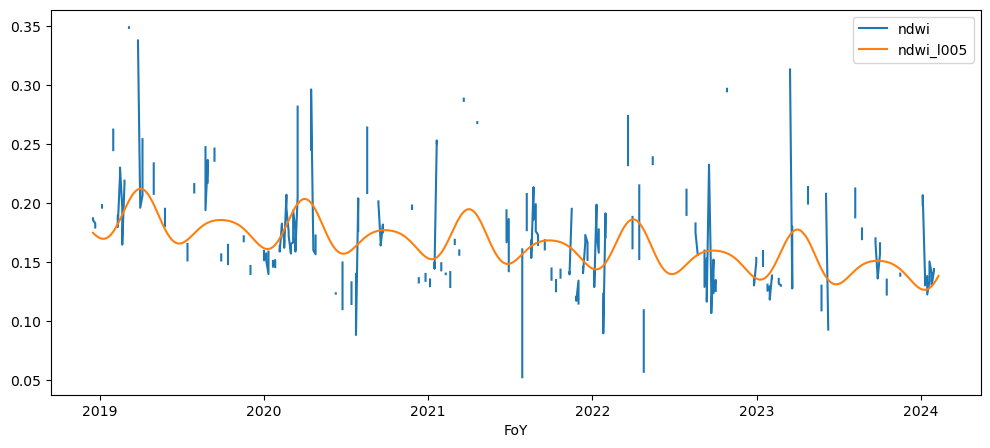

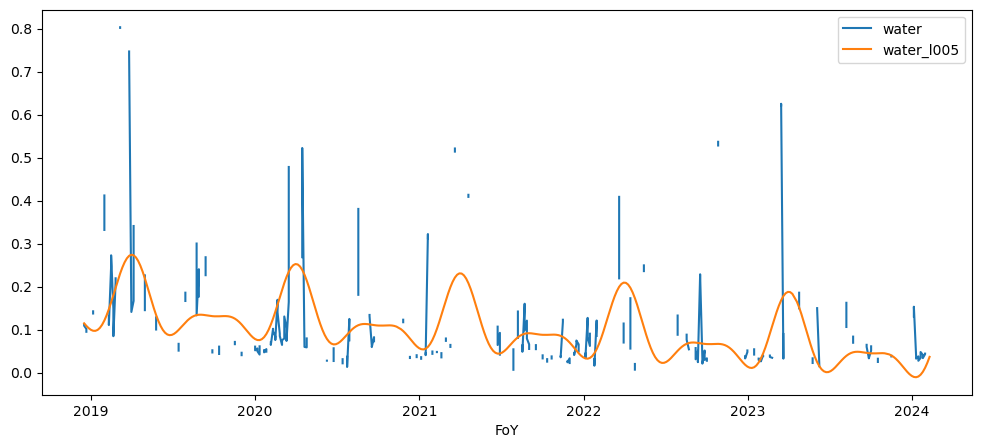

In [27]:
import matplotlib.pyplot as plt
for band in ['B3', 'B8', 'B12', 'ndvi', 'ndwi', 'water']:
    # fig, ax = plt.subplots(figsize=(12, 6))
    df.plot(kind='line', x='FoY', y=[band, f'{band}_l005'], figsize=(12,5))
    # fig.clf()

In [26]:
df.to_csv('outputs/test.csv')

In [9]:
import pandas as pd

pntfc_worldCover = pd.read_csv("data/WorldCover_Stratified_1k_per_cls.csv")
pntfc_wetMask = pd.read_csv("data/wetland_mask_Stratified_5k_per_cls.csv")


pntfc_worldCover[pntfc_worldCover['wetland_label']==4]

,system:index,WorldCover,latitude,longitude,wetland_label,wetland_mask,.geo
66,66,10,6.576431,-76.860170,4,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
67,67,10,4.401430,-69.140049,4,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
76,76,10,1.183126,-69.972697,4,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
109,109,10,4.090164,-68.502424,4,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
137,137,10,4.435387,-72.301490,4,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...,...,...,...
9986,9986,95,5.461802,-77.397812,4,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
9987,9987,95,1.747627,-78.781487,4,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
9989,9989,95,5.448866,-77.373917,4,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
9991,9991,95,3.331447,-77.442728,4,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [33]:
import dask
import dask.dataframe as dd

meta = {'B1': 'float',
 'B11': 'float',
 'B11_l005': 'float',
 'B12': 'float',
 'B12_l005': 'float',
 'B2': 'float',
 'B2_l005': 'float',
 'B3': 'float',
 'B3_l005': 'float',
 'B4': 'float',
 'B4_l005': 'float',
 'B5': 'float',
 'B5_l005': 'float',
 'B6': 'float',
 'B6_l005': 'float',
 'B7': 'float',
 'B7_l005': 'float',
 'B8': 'float',
 'B8A': 'float',
 'B8A_l005': 'float',
 'B8_l005': 'float',
 'B9': 'float',
 'FoY': 'float',
 'ndvi': 'float',
 'ndvi_l005': 'float',
 'ndwi': 'float',
 'ndwi_l005': 'float',
 'water': 'float',
 'water_l005': 'float'}

def sample_location(row):
    """ Sample time series over a given point """
    point = ee.Geometry.Point([row.longtitude, row.latitude])

    def sample_time_series(image):
        return image.reduceRegions(collection=ee.FeatureCollection([point]), reducer=ee.Reducer.mean(), scale=10)\
                    .map(lambda x: x.set('FoY', image.get('FoY')))

    time_series_ccdc = s2ImgCol_ccdc.map(sample_time_series)

    df = geemap.ee_to_df(ee.FeatureCollection(time_series_ccdc.flatten()))
    return df

ddf = dd.read_csv("data/WorldCover_Stratified_1k_per_cls.csv")
ddf = ddf.repartition(100)

df_sum = ddf.apply(sample_location, meta=meta, axis=1)
df_sum

C:\Users\puzh\AppData\Local\Temp\ipykernel_9640\987384618.py:4: FutureWarning: divisions is an integer and will be inferred as npartitions instead. This automatic inference is deprecated and will change in the future. Please set npartitions=100 instead.
  ddf = ddf.repartition(100)


In [41]:
ddf = dd.read_csv("data/WorldCover_Stratified_1k_per_cls.csv")
ddf = ddf.repartition(100)
ddf_ = ddf.get_partition(74).compute()
ddf_

C:\Users\puzh\AppData\Local\Temp\ipykernel_9640\2048731914.py:2: FutureWarning: divisions is an integer and will be inferred as npartitions instead. This automatic inference is deprecated and will change in the future. Please set npartitions=100 instead.
  ddf = ddf.repartition(100)


,system:index,WorldCover,latitude,longitude,wetland_label,wetland_mask,.geo
7773,7773,80,4.297765,-70.123794,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
7774,7774,80,9.039881,-74.868066,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
7775,7775,80,10.490301,-75.109533,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
7776,7776,80,4.901073,-70.166823,8,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
7777,7777,80,9.048146,-74.539642,10,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...,...,...,...
7873,7873,80,8.651630,-74.296738,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
7874,7874,80,-1.255710,-70.919611,8,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
7875,7875,80,4.388405,-72.007561,0,0,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
7876,7876,80,3.706404,-68.842976,8,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [46]:
ddf_.iloc[0].longitude

-70.12379363553183

In [22]:
df_in = pntfc_wetMask
for wetland_label in range(0, 11):
    xx = df_in[df_in['wetland_label']==wetland_label]
    print(f"wetland_label: {wetland_label}, size: {xx.shape[0]}")

wetland_label: 0, size: 5000
wetland_label: 1, size: 1134
wetland_label: 2, size: 834
wetland_label: 3, size: 756
wetland_label: 4, size: 579
wetland_label: 5, size: 475
wetland_label: 6, size: 354
wetland_label: 7, size: 234
wetland_label: 8, size: 226
wetland_label: 9, size: 209
wetland_label: 10, size: 199


In [37]:
df.set_index('FoY')

,B1,B11,B11_l005,B12,B12_l005,B2,B2_l005,B3,B3_l005,B4,...,B8,B8A,B8A_l005,B8_l005,B9,ndvi,ndvi_l005,ndwi,ndwi_l005,water_l005
FoY,,,,,,,,,,,,,,,,,,,,,
2018.958904,0.0584,0.4822,0.494767,0.2806,0.289925,0.0750,0.102062,0.1134,0.138508,0.1086,...,0.3760,0.4230,0.433424,0.382792,0.4342,0.551795,0.738738,-0.536575,0.256093,0.410889
2018.972603,0.1628,0.5310,0.495300,0.3324,0.290610,0.1686,0.102582,0.1996,0.139008,0.1954,...,0.4572,0.5088,0.432354,0.381868,0.9048,0.401165,0.737916,-0.392205,0.256730,0.407581
2018.986301,0.0626,0.5144,0.496639,0.3084,0.291978,0.0794,0.103151,0.1172,0.139603,0.1216,...,0.3716,0.4252,0.431483,0.381159,0.4350,0.506894,0.736648,-0.520458,0.257570,0.405634
2019.000000,NaN,NaN,0.499108,NaN,0.294215,NaN,0.103832,NaN,0.140322,NaN,...,NaN,NaN,0.430859,0.380704,NaN,NaN,0.734905,NaN,0.258640,0.405684
2019.013699,0.0770,0.5534,0.502963,0.3372,0.297466,0.0920,0.104683,0.1272,0.141190,0.1478,...,0.3660,0.4152,0.430509,0.380522,0.4250,0.424679,0.732674,-0.484185,0.259963,0.408311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024.051913,0.0866,0.4458,0.522036,0.2284,0.297903,0.0990,0.108391,0.1292,0.144537,0.1284,...,0.3592,0.3878,0.451855,0.399902,0.3840,0.473339,0.740514,-0.470925,0.265081,0.387007
2024.065574,0.0842,0.5188,0.531688,0.3078,0.305181,0.0872,0.110291,0.1232,0.146072,0.1490,...,0.3752,0.4200,0.452454,0.400626,0.4338,0.431515,0.736630,-0.505618,0.267407,0.402415
2024.079235,0.0810,0.5566,0.542489,0.3418,0.313253,0.1004,0.112506,0.1296,0.147768,0.1582,...,0.3760,0.4246,0.453202,0.401485,0.4310,0.407712,0.732450,-0.487342,0.269961,0.421185


In [36]:
from ccdc import millis_to_fractionOfYear

check_date = '2020-09-01'
FoY = millis_to_fractionOfYear(ee.Date(check_date).millis())
filter_FoY = ee.Filter.And(ee.Filter.gte('FoY', FoY), ee.Filter.lte('FoY', FoY.add(0.1)))
check_img = s2ImgCol_ccdc.filter(filter_FoY).first()
print('image date: ', check_img.date().format().getInfo())

Map.addLayer(check_img, {'bands': ['B4_l005', 'B3_l005', 'B2_l005'], 'min': 0, 'max': 0.2}, 'Sentinel-2 CCDC')
Map.addLayer(check_img, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.2}, 'Sentinel-2')

image date:  2020-09-02T15:21:44


In [38]:

df.to_xarray()

<xarray.Dataset>
Dimensions:     (index: 374)
Coordinates:
  * index       (index) int64 0 1 2 3 4 5 6 7 ... 367 368 369 370 371 372 373
Data variables: (12/28)
    B1          (index) float64 0.0584 0.1628 0.0626 nan ... 0.081 nan nan
    B11         (index) float64 0.4822 0.531 0.5144 nan ... 0.5566 nan nan
    B11_l005    (index) float64 0.4948 0.4953 0.4966 ... 0.5425 0.5541 0.566
    B12         (index) float64 0.2806 0.3324 0.3084 nan ... 0.3418 nan nan
    B12_l005    (index) float64 0.2899 0.2906 0.292 ... 0.3133 0.3219 0.3308
    B2          (index) float64 0.075 0.1686 0.0794 nan ... 0.1004 nan nan
    ...          ...
    FoY         (index) float64 2.019e+03 2.019e+03 ... 2.024e+03 2.024e+03
    ndvi        (index) float64 0.5518 0.4012 0.5069 nan ... 0.4077 nan nan
    ndvi_l005   (index) float64 0.7387 0.7379 0.7366 ... 0.7324 0.7281 0.7236
    ndwi        (index) float64 -0.5366 -0.3922 -0.5205 nan ... -0.4873 nan nan
    ndwi_l005   (index) float64 0.2561 0.2567 0.2576 ... 0.27 0.2727 0.2756
    water_l005  (index) float64 0.4109 0.4076 0.4056 ... 0.4212 0.4429 0.4671

In [33]:
import geemap

Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## animation

In [59]:
import xarray as xr

aoi = poi.buffer(2500).bounds(); # 2kernelSize * 2kernelSize
s2ImgCol_ccdc = s2ImgCol_ccdc.map(lambda img: img.setDefaultProjection(crs='EPSG:4326', scale=10))
ds = xr.open_dataset(s2ImgCol_ccdc.filter(filter_FoY), 
                         engine='ee', 
                         projection=s2ImgCol_ccdc.first().select(0).projection(),
                        #  crs='EPSG:32608',
                         # geometry= i.first().geometry(),
                         geometry=aoi,
                        #  scale=10
                    )

ds

<xarray.Dataset>
Dimensions:     (time: 8, lon: 602, lat: 601)
Coordinates:
  * time        (time) datetime64[ns] 2020-09-02T15:21:44.926000 ... 2020-10-...
  * lon         (lon) float32 -72.22 -72.22 -72.22 ... -72.17 -72.17 -72.17
  * lat         (lat) float32 4.583 4.583 4.583 4.583 ... 4.53 4.53 4.529 4.529
Data variables: (12/27)
    B1          (time, lon, lat) float32 ...
    B2          (time, lon, lat) float32 ...
    B3          (time, lon, lat) float32 ...
    B4          (time, lon, lat) float32 ...
    B5          (time, lon, lat) float32 ...
    B6          (time, lon, lat) float32 ...
    ...          ...
    B8A_l005    (time, lon, lat) float64 ...
    B11_l005    (time, lon, lat) float64 ...
    B12_l005    (time, lon, lat) float64 ...
    ndvi_l005   (time, lon, lat) float64 ...
    ndwi_l005   (time, lon, lat) float64 ...
    water_l005  (time, lon, lat) float64 ...
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:4326

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

BAND = 'B12_l005'
# Setting up the figure
fig, ax = plt.subplots()
cax = ax.matshow(ds.isel(time=0)[BAND], cmap='viridis')
fig.colorbar(cax, label='Temperature (°C)')

# def animate(i):
#     cax.set_data(ds[BAND].isel(time=i))
#     ax.set_title(f"Time: {ds.time.isel(time=i).values}")
#     return cax, ax

# # Creating the animation
# ani = FuncAnimation(fig, animate, frames=len(ds.time), interval=200)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

BAND = 'B12_l005'
# Setting up the figure
fig, ax = plt.subplots()
cax = ax.matshow(ds.isel(time=0)[BAND], cmap='viridis')
fig.colorbar(cax, label='Temperature (°C)')

# def animate(i):
#     cax.set_data(ds[BAND].isel(time=i))
#     ax.set_title(f"Time: {ds.time.isel(time=i).values}")
#     return cax, ax

# # Creating the animation
# ani = FuncAnimation(fig, animate, frames=len(ds.time), interval=200)

plt.show()


In [ ]:
""" animation with lon/lat """
import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy.crs as ccrs
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap

band_name = 'ndvi_l005'
vmin = 0
vmax = 0.05
palette = ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
cmap = LinearSegmentedColormap.from_list("my_colormap", palette)


da = ds[band_name]

fig = plt.figure(figsize=(10, 5)) # Define the figure and specify size
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree()) # Specify plot area & projection
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
ax.set_title(f'{band_name}, {str(da.time[0].values)[:-16]}', fontsize=12) # Set figure title
ax.coastlines(color='black') # Add coastlines
if 'lon' in ds.dims.keys():
    im = plt.pcolormesh(da.lon, da.lat, da[0,:,:].transpose(), cmap=cmap, vmin=vmin, vmax=vmax) # Plot the data
if 'X' in ds.dims.keys():
    im = plt.pcolormesh(da.X, da.Y, da[0,:,:].transpose(), cmap=cmap, vmin=vmin, vmax=vmax) # Plot the data
cbar = plt.colorbar(im, fraction=0.046, pad=0) # Specify the colourbar
cbar.set_label(f'{band_name}') # Define the colourbar label

frames = da.shape[0]
def animate(i):
    array = da[i,:,:].transpose().values
    im.set_array(array.flatten())
    # plt.imshow(da[i,:,:])
    ax.set_title(f'{band_name}, {str(da.time[i].values)[:-frames]}', fontsize=12)

fig.tight_layout()

ani = animation.FuncAnimation(fig, animate, frames, interval=150)
ani.save(f'outputs/{band_name}_animation.gif') # save to animated gif
HTML(ani.to_jshtml())